#Introduction to Deep Learning 2024-2
## Cardiac Arrhythmia challenge


Steps to run notebook:
1. Create a copy of this folder in your drive
2. Run the first code block
3. Change 'data_path' to the location of the folder (open folder icon on the left, navigate to this folder, click the 3 dots on the right of the folder to copy path to the folder)







In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# PATH TO THIS FOLDER IN DRIVE
# You must change this path by the corresponding direction of your file
data_path = "/content/gdrive/MyDrive/Challenge Arritmias"


In [ ]:
#data libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py

#model libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# Extracting the Training Data
The training data is saved in the file 'training_set_500.h5', which is in [h5
format](https://fileinfo.com/extension/h5).  This format allows to save Hierarchical Data.  In this file we have saved the 'data' and the 'labels'

We extract the 'data' and the 'labels' to the variables X_train and y_train respectively and then convert these variable into numpy arrays.

**The dataset has 3 labels :**

*   0: Normal
*   1: Arrhythmia
*   2: Noise




In [ ]:
# Traing Data - ECG signals from 500 patients
dataset = h5py.File(data_path + '/training_set_500.h5', 'r')

X_train = dataset.get('data')
X_train = np.array(X_train)
y_train = dataset.get('labels')
y_train = np.array(y_train)
dataset.close()

# Healthy assertion
assert X_train.shape == (116953, 2049, 1)  # The training data has 116953 1D ECG signals each one with 2049 samples
assert y_train.shape == (116953, 1) # 116953 labels (0: Normal, 1: Cardiac Arrhytmia, 2: Noise signal)


In [ ]:
nclases = 3
y_train = to_categorical(y_train, nclases)
y_train.shape

(116953, 3)

In [ ]:
from sklearn.model_selection import train_test_split

# Separar el conjunto de datos en 80% para entrenamiento y 20% para validación
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Ahora X_train_split y y_train_split contienen el 80% de los datos para entrenamiento,
# mientras que X_val_split y y_val_split contienen el 20% restante para validación.

# Verifica las dimensiones de las nuevas particiones
print(f'Tamaño de X_train: {X_train.shape}')
print(f'Tamaño de X_val: {X_val_split.shape}')
print(f'Tamaño de y_train: {y_train.shape}')
print(f'Tamaño de y_val: {y_val_split.shape}')

Tamaño de X_train: (116953, 2049, 1)
Tamaño de X_val: (23391, 2049, 1)
Tamaño de y_train: (116953, 3)
Tamaño de y_val: (23391, 3)


In [ ]:
import numpy as np

# Convertir las etiquetas one-hot a etiquetas de clase
y_train_split_classes = np.argmax(y_train_split, axis=1)

# Contar cuántas muestras hay por cada clase
unique, counts = np.unique(y_train_split_classes, return_counts=True)
print("Datos para entrenamiento:")
# Crear un diccionario con las categorías y sus respectivas frecuencias
categories = {0: 'Normal', 1: 'Cardiac Arrhythmia', 2: 'Noise'}
category_counts = dict(zip(unique, counts))

# Mostrar la distribución de las clases en X_train_split
for category, count in category_counts.items():
    print(f'{categories[category]}: {count} samples')


Datos para entrenamiento:
Normal: 52157 samples
Cardiac Arrhythmia: 3804 samples
Noise: 37601 samples


In [ ]:
# Convertir las etiquetas one-hot de validación a etiquetas de clase
y_val_split_classes = np.argmax(y_val_split, axis=1)

# Contar cuántas muestras hay por cada clase en el conjunto de validación
unique_val, counts_val = np.unique(y_val_split_classes, return_counts=True)

# Crear un diccionario con las categorías y sus respectivas frecuencias
category_counts_val = dict(zip(unique_val, counts_val))
print("Datos para validacion")
# Mostrar la distribución de las clases en X_val_split
for category, count in category_counts_val.items():
    print(f'{categories[category]}: {count} samples')


Datos para validacion
Normal: 13039 samples
Cardiac Arrhythmia: 951 samples
Noise: 9401 samples


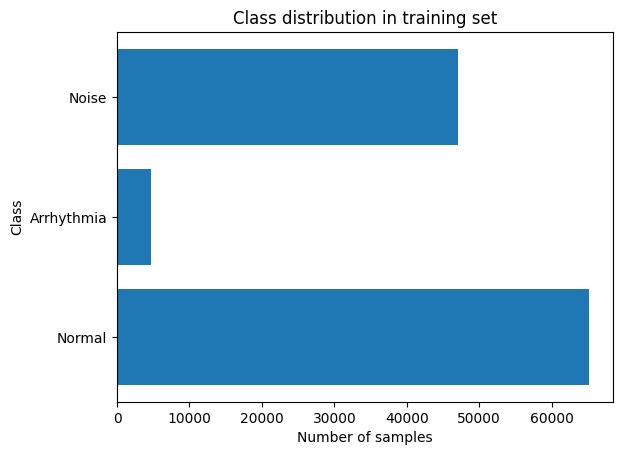

In [ ]:
# Obtener la distribución de clases
classes, counts = np.unique(y_train.argmax(axis=1), return_counts=True)

# Etiquetas de las clases
class_names = ['Normal', 'Arrhythmia', 'Noise']

# Graficar la distribución de clases
plt.barh(class_names, counts)
plt.title('Class distribution in training set')
plt.xlabel('Number of samples')
plt.ylabel('Class')
plt.show()

In [ ]:
for class_name, count in zip(class_names, counts):
    print(f"{class_name}: {count} ")

Normal: 65196 
Arrhythmia: 4755 
Noise: 47002 


# Extracting the Test Data
The test data is saved in the file '/test_without_labels_200.h5', which is also in [h5
format](https://fileinfo.com/extension/h5).  
We extract the 'data' to the variable X_test. **Please note that the test labels  are hidden for challenge purposes.**

In [ ]:
# Testing Data - ECG signals from 200 patients
dataset = h5py.File(data_path + '/test_without_labels_200.h5', 'r')

X_test = dataset.get('data')
X_test = np.array(X_test)
dataset.close()

# Healthy assertion
assert X_test.shape == (46943, 2049, 1) # 46943 1D ECG signal each one with 2049 samples

## Sketching some ECG Signal

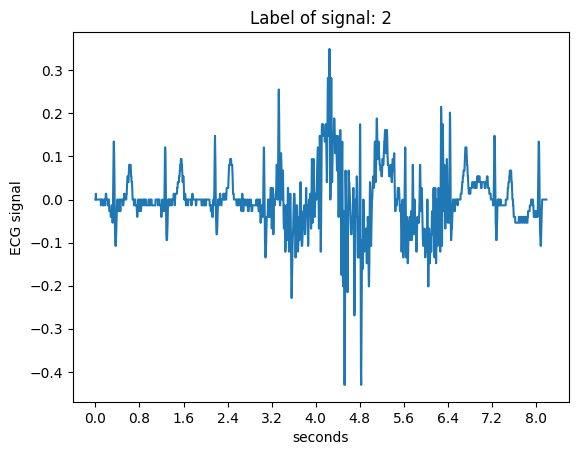

In [ ]:
index = 763

x=np.arange(0,2048,200)
xi = x/250 # sample rate of recording: 250Hz
plt.xticks(x,xi)
plt.plot(X_train[index])
plt.title('Label of signal: %i'  % np.argmax(y_train[index]))
plt.xlabel('seconds')
plt.ylabel('ECG signal')

plt.show()

#Model

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Flatten

def model_cnn12():
    # Definir la entrada
    inputs = keras.layers.Input(shape=(2049, 1))

    # Primer bloque convolucional
    x = keras.layers.Conv1D(filters=16, kernel_size=16, padding='same', kernel_initializer='he_normal')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # Rama 1 bloque convolucional con strides=2
    x1 = keras.layers.Conv1D(filters=16, strides=2, kernel_size=16, padding='same', kernel_initializer='he_normal')(x)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same')(x1)

    # Rama 2 bloque convolucional
    x2 = keras.layers.MaxPool1D(pool_size=2, padding='same')(x)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=8, kernel_size=1, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2
    acum = keras.layers.Add()([x1, x2])

    # N = 1 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, strides=2,padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, strides= 2, padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=8, kernel_size=1, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

        # N = 2 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=8, kernel_size=1, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

        # N = 3 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=8, kernel_size=1, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

        # N = 4 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=8, kernel_size=1, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

        # N = 5 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=8, kernel_size=1, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

        # N = 6 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=8, kernel_size=1, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

        # N = 7 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=8, kernel_size=1, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

        # N = 8 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=16, strides=1, kernel_size=16, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=8, kernel_size=1, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

            # N = 9 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=32, strides=1, kernel_size=32, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=32, strides=1, kernel_size=32, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, strides=2,  padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=32, kernel_size=32, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

                # N = 10 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=32, strides=1, kernel_size=32, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=32, strides=1, kernel_size=32, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, strides=1, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, strides=1,  padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=32, kernel_size=32, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

                # N = 11 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=32, strides=1, kernel_size=32, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=32, strides=1, kernel_size=32, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, strides=1, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, strides=1,  padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=32, kernel_size=32, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

    # N = 12 (residual)
    x1 = keras.layers.BatchNormalization()(acum)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Conv1D(filters=32, strides=1, kernel_size=32, padding='same',kernel_initializer='he_normal')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.ReLU()(x1)
    x1 = keras.layers.Dropout(0.3)(x1)
    x1 = keras.layers.Conv1D(filters=32, strides=1, kernel_size=32, padding='same',  kernel_initializer='he_normal')(x1)
    x1 = keras.layers.AveragePooling1D(pool_size=2, strides=1, padding='same')(x1)

    x2 = keras.layers.MaxPool1D(pool_size=2, strides=1,  padding='same')(acum)

    # Asegurarse de que las dimensiones de x1 y x2 coincidan para la suma
    if x1.shape[-1] != x2.shape[-1]:
        x2 = keras.layers.Conv1D(filters=32, kernel_size=32, padding='same',  kernel_initializer='he_normal')(x2)  # Ajustar filtros

    # Concatenar x1 y x2 de nuevo
    acum = keras.layers.Add()([x1, x2])

    xf = keras.layers.BatchNormalization()(acum)
    xf = keras.layers.ReLU()(xf)

    # Aplanado y capa densa de salida
    x3 = Flatten()(xf)  # Aplanar la concatenación
    x3 = keras.layers.Dense(3)(x3)
    x3 = keras.layers.Dense(3, activation='softmax')(x3)

    # Crear el modelo
    conv_model = keras.Model(inputs=inputs, outputs=x3)

    return conv_model

model = model_cnn12()
model_cnn12().summary()
keras.utils.plot_model(model, "Project_model.png", show_shapes=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 2049, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_196 (Conv1D)       │ (None, 2049, 16)       │            272 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 2049, 16)       │             64 │ conv1d_196[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_189 (ReLU)          │ (None, 2049, 16)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_197 (Conv1D)       │ (None, 1025, 16)       │          4,112 │ re_lu_189[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 1025, 16)       │             64 │ conv1d_197[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_190 (ReLU)          │ (None, 1025, 16)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_91 (Dropout)      │ (None, 1025, 16)       │              0 │ re_lu_190[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_198 (Conv1D)       │ (None, 1025, 16)       │          4,112 │ dropout_91[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_91          │ (None, 1025, 16)       │              0 │ re_lu_189[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_91 (Add)              │ (None, 1025, 16)       │              0 │ conv1d_198[0][0],      │
│                           │                        │                │ max_pooling1d_91[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 1025, 16)       │             64 │ add_91[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_191 (ReLU)          │ (None, 1025, 16)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_199 (Conv1D)       │ (None, 1025, 16)       │          4,112 │ re_lu_191[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_192   │ (None, 1025, 16)       │             64 │ conv1d_199[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_192 (ReLU)          │ (None, 1025, 16)       │              0 │ batch_normalization_1… │
├──────────────────────

 Total params: 339,263 (1.29 MB)

 Trainable params: 338,143 (1.29 MB)

 Non-trainable params: 1,120 (4.38 KB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.800718 to fit



In [ ]:
model.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)

callback_es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1)
callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
callback_check = keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Challenge Arritmias/checkpoint2.model.keras',monitor = 'val_loss', save_best_only=True,mode='min',verbose=1)
callbacks = [callback_es, callback_reduce_lr, callback_check]

history = model.fit(
    X_train_split, y_train_split,
    #validation_split=0.2,
    validation_data=(X_val_split, y_val_split),
    batch_size=128,
    epochs=50,
    callbacks = callbacks
)


Epoch 1/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8200 - loss: 0.4617
Epoch 1: val_loss improved from inf to 0.35074, saving model to /content/gdrive/MyDrive/Challenge Arritmias/checkpoint2.model.keras
731/731 ━━━━━━━━━━━━━━━━━━━━ 108s 87ms/step - accuracy: 0.8201 - loss: 0.4615 - val_accuracy: 0.8560 - val_loss: 0.3507 - learning_rate: 0.0010
Epoch 2/50
730/731 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9013 - loss: 0.2456
Epoch 2: val_loss improved from 0.35074 to 0.20378, saving model to /content/gdrive/MyDrive/Challenge Arritmias/checkpoint2.model.keras
731/731 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.9013 - loss: 0.2456 - val_accuracy: 0.9208 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 3/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9139 - loss: 0.2149
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 3: val_loss did not improve from 0.20378
731/731 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.91

731/731 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


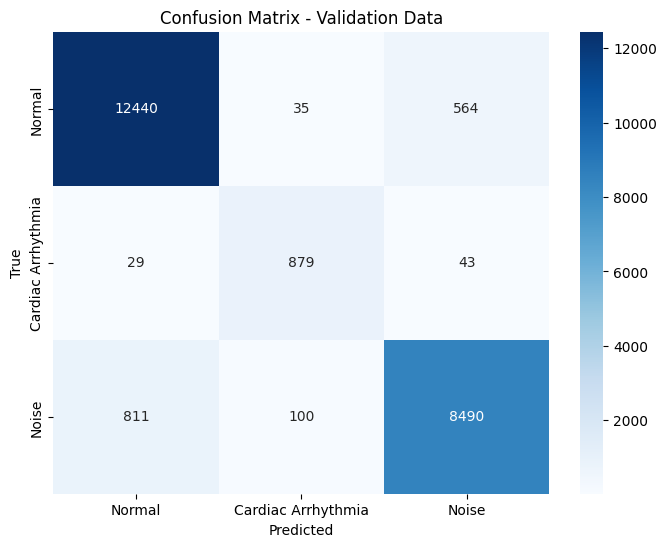

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Realiza la predicción sobre el conjunto de validación
y_pred = model.predict(X_val_split)

# Convertir las predicciones a las clases (es decir, tomar el índice con la mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val_split, axis=1)

# Generar la matriz de confusión
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Cardiac Arrhythmia', 'Noise'],
            yticklabels=['Normal', 'Cardiac Arrhythmia', 'Noise'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Data')
plt.show()


In [ ]:
from sklearn.metrics import f1_score

# Calcular el F1 Score

f1_per_class = f1_score(y_val_classes, y_pred_classes, average=None)

print(f'F1 Score por clases: {f1_per_class*100}')

F1 Score por clases: [94.53246704 89.46564885 91.79370743]


In [ ]:
# Inicializar un diccionario para almacenar los F1 Scores
f1_scores = {}
categories = {0: 'Normal', 1: 'Cardiac Arrhythmia', 2: 'Noise'}

# Calcular el F1 Score para cada clase
for i in range(len(categories)):
    TP = cm[i, i]  # Verdaderos positivos
    FP = np.sum(cm[:, i]) - TP  # Falsos positivos
    FN = np.sum(cm[i, :]) - TP  # Falsos negativos

    # Calcular Precision y Recall
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calcular F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Almacenar el F1 Score en el diccionario
    f1_scores[categories[i]] = f1_score

# Mostrar los F1 Scores
for category, f1 in f1_scores.items():
    print(f'F1 Score para {category}: {f1:.4f}')


F1 Score para Normal: 0.9453
F1 Score para Cardiac Arrhythmia: 0.8947
F1 Score para Noise: 0.9179


# Calculate the predictions on the X_test, save and submit the results

When you are satisfied with your results:

*   Calculate y_pred, which is the prediction for the X_test
*   Save it on a .npy file
*   Submit your results on the Classroom

I will sent you the accuracy on this file.

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
assert y_pred.shape == (46943,3)


1467/1467 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [ ]:
print(y_pred)

[[0 0 1]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [1 0 0]]


In [ ]:
#FILE FOR SUBMISSION
# Example: '/content/gdrive/MyDrive/C1_2181727_2182344_CamiloSantos_CarlosFajardo_prediction'
np.save('/content/gdrive/MyDrive/C1_2192987_2194677_GersonSanchez_ElianaGonzalez_prediction',y_pred)